<a href="https://colab.research.google.com/github/iGeology-Illinois/geol-581-module-3-principles-of-uncertainty-chapter-4-seanb7/blob/main/GEOL_581_Module_5_Slope_Stability_Analyses_no1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOL 581: Module 5 | Slope Stability Analyses

## Introduction

In this notebook, we will explore how to apply and compare different slope stability approaches, referencing the methods described in the textbook sections on kinematic and mechanical preconditions, plane/rotational sliding, and the method of slices (including Figs. 10.31–10.37, etc.). We will use Python to model:

- Plane sliding in non-cohesive soils (and how friction angle and slope angle interplay).  
- The method of slices in cohesive soils (membrane vs. flow net solutions).  
- Sensitivity analyses, to see how factor of safety changes with varying parameters.

Some key ideas from the referenced pages:

1. Kinematic and Mechanical Preconditions  
   - A slope can fail only if it is capable of forming a particular failure mechanism (kinematic condition)  
   - And if a trigger disturbs the force equilibrium (mechanical condition).

2. Plane Sliding vs. Rotational Sliding  
   - Plane sliding is when the failure surface is roughly planar (Fig. 10.31, 10.32).  
   - Rotational sliding is when the failure surface is curved, often occurring in cohesive soils (Fig. 10.34, 10.35).

3. Method of Slices  
   - We divide the potential sliding mass into vertical slices.  
   - Each slice’s forces (weight, cohesion, friction, pore-water pressures) are evaluated.  
   - Two approaches, referencing Fig. 10.37:  
     - Membrane solution: Groundwater is interpreted as acting along a membrane on the slip surface.  
     - Flow net solution: Uses equipotential lines and flow nets to apply seepage forces directly within each slice.

Below, you will find three main coding tasks, each preceded by explanatory Markdown cells that guide your analysis. This assignment is deliberately open-ended so you can adapt or extend the models to more complex scenarios.


## Part 1 Instructions

1. Review how the equilibrium of forces is established for plane sliding in non-cohesive soil.  
   - Check Figures 10.31 and 10.32 for the polygon of forces.  
   - Account for friction angle φ and slope angle β.  
   - (Optionally) consider seepage forces if the groundwater table intersects the slope.

2. Modify the `plane_sliding_fos` function to incorporate additional parameters:
   - Buoyancy or seepage if the water table is parallel to the slope (Fig. 10.32).
   - External loads if relevant.

3. Discuss in a separate Markdown cell how your final formula differs from the simplified example above.


In [1]:
# Part 1: Basic Plane Sliding
# We'll begin with a simple function to estimate a factor of safety (FOS) for plane sliding.
# This function is intentionally simplified. Refer back to Figures 10.31 and 10.32 in the textbook
# for details about how to incorporate seepage forces, partial saturation, etc.

import numpy as np

def plane_sliding_fos(phi_deg, beta_deg):
    """
    Computes a very simplified factor of safety for plane sliding in non-cohesive soil.
    phi_deg : friction angle (degrees)
    beta_deg: slope angle (degrees)
    Returns : factor of safety (dimensionless)
    """
    phi = np.radians(phi_deg)
    beta = np.radians(beta_deg)

    # For demonstration: ratio of available friction to driving shear
    # This is NOT a full formula; adapt from the text's equations if desired.
    if np.tan(beta) == 0:
        return np.inf

    fos = np.tan(phi) / np.tan(beta)
    return fos

# Example usage:
phi_test = 30.0  # friction angle in degrees
beta_test = 25.0 # slope angle in degrees
fos_result = plane_sliding_fos(phi_test, beta_test)
print(f"Plane sliding FOS with phi={phi_test}°, beta={beta_test}°: {fos_result:.3f}")


Plane sliding FOS with phi=30.0°, beta=25.0°: 1.238


In [5]:
import math

def calculate_fos(weight, slope_angle, cohesion, friction_angle, pore_water_pressure, seepage_force):
    # Convert angles from degrees to radians
    slope_angle_rad = math.radians(slope_angle)
    friction_angle_rad = math.radians(friction_angle)

    # Calculate normal force (N)
    normal_force = weight * math.cos(slope_angle_rad)

    # Calculate shear force due to weight (W_shear)
    shear_force_weight = weight * math.sin(slope_angle_rad)

    # Calculate buoyancy force (B)
    buoyancy_force = pore_water_pressure * math.cos(slope_angle_rad)

    # Calculate effective normal force (N')
    effective_normal_force = normal_force - buoyancy_force

    # Calculate resisting force (R)
    resisting_force = cohesion + (effective_normal_force * math.tan(friction_angle_rad))

    # Calculate driving force (D)
    driving_force = shear_force_weight + seepage_force

    # Calculate Factor of Safety (FoS)
    fos = resisting_force / driving_force

    return fos

# Example parameters
weight = 10000  # in Newtons
slope_angle = 30  # in degrees
cohesion = 500  # in Newtons
friction_angle = 35  # in degrees
pore_water_pressure = 2000  # in Newtons
seepage_force = 1500  # in Newtons

# Calculate FoS
fos = calculate_fos(weight, slope_angle, cohesion, friction_angle, pore_water_pressure, seepage_force)
print(f"Factor of Safety (FoS): {fos:.2f}")

Factor of Safety (FoS): 0.82


A noticable difference in terms of the simplified equation and the equation created is that for every new force or applied to the FoS, we see a decrease in stability or saftey.

## Part 2 Instructions

1. Analyze the functions `fos_slices_membrane` and `fos_slices_flownet`:
   - How are they currently summing the forces among slices?
   FoS_membrane function is calculating the force by dividing the resisting force by the driving force. The resisting force is the shear resistance enacted upon all slices, where the driving force is the sum of the downslope weight.
   FoS_flownet function sums up the acting force among slices but the driving force is affected by the normal force which can/is reduced by the pore pressure.
   - Where can you incorporate real data or a more rigorous approach (e.g., geometry of the slip surface, slice base angles, etc.)?
   Current assumption is that all slices have the same height creating a uniform constant angle, most things in nature are not uniform. Knowing this we can apply a data as a circular or planar slip surface giving each slice its own individual base inclination angle. If the water table is known we can use a flow new analysis to calculate pore pressure for each slice. Lastly we could apply the properties from the terrain profile, inputing the correct coordinates and using a defined slip surface will allow us to break the slices vertically so we can then compute the width area and base length of the actual slice.

2. Revise one or both functions to reflect your course’s recommended method for computing the factor of safety.
   - You might need to include more realistic geometry or moment equilibrium.  
   - Alternatively, you can keep it simple but justify your assumptions.

3. Document how your approach corresponds to the textbook’s Figures 10.37 and 10.38 (membrane vs. flow net solutions, interacting blocks, etc.).


In [2]:
# Part 2: Method of Slices (Membrane vs. Flow Net)
# For cohesive soils, we can implement a simplified method of slices approach.
# Reference Fig. 10.37 from the textbook. We'll build two functions:
#   - One using a "membrane" interpretation of groundwater
#   - One using a "flow net" approach with each slice having distinct pore pressures.

import numpy as np

def fos_slices_membrane(n_slices, slope_height, c, phi_deg, gamma_soil):
    """
    Very simplified demonstration of a 'membrane solution' approach.
    n_slices     : number of slices
    slope_height : total slope height (m)
    c            : cohesion (kN/m^2)
    phi_deg      : friction angle (degrees)
    gamma_soil   : soil unit weight (kN/m^3)
    Returns an approximate factor of safety.
    """
    phi = np.radians(phi_deg)

    # For demonstration: assume each slice is of equal width
    slice_width = 2.0  # arbitrary
    slice_heights = np.linspace(1, slope_height, n_slices)

    R_total = 0.0
    D_total = 0.0

    for h_slice in slice_heights:
        # Weight of slice (assuming some unit thickness)
        W = gamma_soil * slice_width * h_slice

        # Simplistic normal force
        N = W * np.cos(phi)

        # Shear resistance from cohesion plus friction
        S_res = c * slice_width + N * np.tan(phi)

        # Driving force
        D = W * np.sin(phi)

        R_total += S_res
        D_total += D

    if D_total == 0:
        return np.inf
    return R_total / D_total


def fos_slices_flownet(n_slices, slope_height, c, phi_deg, gamma_soil):
    """
    Simplified demonstration of a 'flow net solution' approach.
    We'll add random or parametric pore water pressure for each slice.
    """
    phi = np.radians(phi_deg)
    slice_width = 2.0
    slice_heights = np.linspace(1, slope_height, n_slices)

    R_total = 0.0
    D_total = 0.0

    rng = np.random.default_rng(seed=42)  # reproducible random values

    for h_slice in slice_heights:
        W = gamma_soil * slice_width * h_slice

        # Assign a random pore pressure ratio in [0, 0.3]
        ru = rng.random() * 0.3

        # Effective normal force
        N_eff = (W * np.cos(phi)) * (1 - ru)

        # Shear resistance
        S_res = c * slice_width + N_eff * np.tan(phi)

        # Driving force
        D = W * np.sin(phi)

        R_total += S_res
        D_total += D

    if D_total == 0:
        return np.inf
    return R_total / D_total

# Demonstration usage:
fos_membrane_demo = fos_slices_membrane(n_slices=5, slope_height=10.0, c=10.0, phi_deg=25.0, gamma_soil=18.0)
fos_flownet_demo = fos_slices_flownet(n_slices=5, slope_height=10.0, c=10.0, phi_deg=25.0, gamma_soil=18.0)

print(f"Membrane solution FOS (example): {fos_membrane_demo:.3f}")
print(f"Flow net solution FOS (example): {fos_flownet_demo:.3f}")


Membrane solution FOS (example): 1.239
Flow net solution FOS (example): 1.094


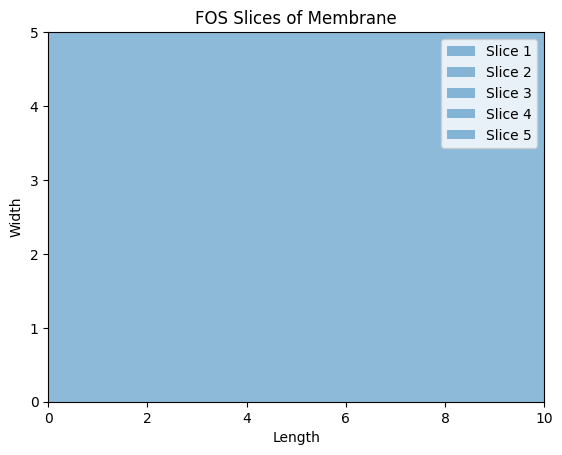

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class FOSMembrane:
    def __init__(self, length, width, num_slices):
        self.length = length
        self.width = width
        self.num_slices = num_slices
        self.slices = []

    def generate_slices(self):
        slice_width = self.width / self.num_slices
        for i in range(self.num_slices):
            start = i * slice_width
            end = start + slice_width
            self.slices.append((start, end))

    def visualize_slices(self):
        fig, ax = plt.subplots()
        for i, (start, end) in enumerate(self.slices):
            rect = plt.Rectangle((0, start), self.length, end - start, alpha=0.5, label=f'Slice {i+1}')
            ax.add_patch(rect)
        ax.set_xlim(0, self.length)
        ax.set_ylim(0, self.width)
        ax.set_xlabel('Length')
        ax.set_ylabel('Width')
        ax.set_title('FOS Slices of Membrane')
        ax.legend()
        plt.show()

# Example usage
membrane = FOSMembrane(length=10, width=5, num_slices=5)
membrane.generate_slices()
membrane.visualize_slices()

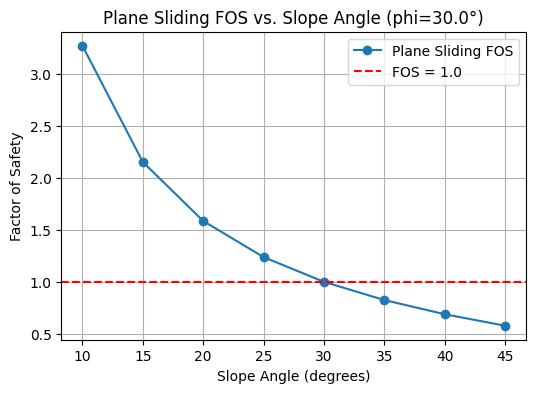

In [19]:
# Part 3: Sensitivity Analysis & Visualization
# Let's conduct a short sensitivity analysis by varying slope angle or pore pressure ratio,
# compute factor of safety, and then plot the results.

import numpy as np
import matplotlib.pyplot as plt

def plane_sliding_sensitivity(phi_deg, slope_angles):
    """
    Returns a list of factor of safety values for an array of slope angles
    using the plane_sliding_fos function from Part 1.
    """
    fos_list = []
    for beta in slope_angles:
        fos_val = plane_sliding_fos(phi_deg, beta)
        fos_list.append(fos_val)
    return fos_list

slope_angles_array = range(10, 46, 5)  # from 10 to 45 in steps of 5
phi_demo = 30.0
fos_vs_beta = plane_sliding_sensitivity(phi_demo, slope_angles_array)

plt.figure(figsize=(6,4))
plt.plot(list(slope_angles_array), fos_vs_beta, 'o-', label="Plane Sliding FOS")
plt.axhline(y=1.0, color='r', linestyle='--', label="FOS = 1.0")
plt.xlabel("Slope Angle (degrees)")
plt.ylabel("Factor of Safety")
plt.title(f"Plane Sliding FOS vs. Slope Angle (phi={phi_demo}°)")
plt.grid(True)
plt.legend()
plt.show()


## Part 3 Instructions

1. Experiment with the above sensitivity analysis:
   - Vary angles, friction angles, cohesion, or random pore pressure parameters.
   - Compare how quickly your slope’s FOS drops below 1.0.

2. Visualize your final results:
   - Possibly create multiple subplots for different conditions (e.g., dry vs. saturated slope).
   - Show how the FOS changes with each parameter and discuss your findings.

3. Write a brief conclusion in another Markdown cell:
   - Summarize the main insights from your numerical experiments.
   - Reflect on how well these simplified models approximate real slope behavior.

### Submission Notes

- Upload your final notebook to the class repository.
- Ensure that each part (plane sliding, method of slices, and sensitivity analysis) is fully documented.
- Discuss any real-world complexities (non-homogeneous soils, layered strata, seismic loads, etc.) that are simplified here.
- Reference the relevant textbook pages (Figs. 10.31–10.38) wherever applicable.

End of Assignment


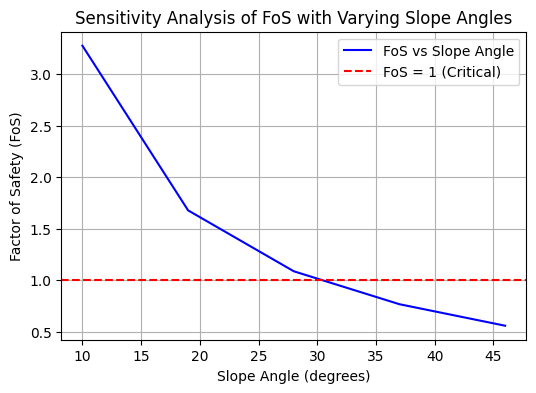

In [13]:
# Dry Slopes
import numpy as np
import matplotlib.pyplot as plt

# Constants
cohesion = 0  # Cohesion (c) in kPa
unit_weight = 20  # Unit weight (γ) in kN/m³
friction_angle = 30  # Friction angle (φ) in degrees

# Function to calculate FoS
def calculate_fos(slope_angle, cohesion, unit_weight, friction_angle):
    slope_angle_rad = np.radians(slope_angle)
    friction_angle_rad = np.radians(friction_angle)
    return (cohesion + unit_weight * np.cos(slope_angle_rad) * np.tan(friction_angle_rad)) / (unit_weight * np.sin(slope_angle_rad))

# Slope angles for analysis
slope_angles = np.linspace(10, 46, 5)

# Calculate FoS for each slope angle
fos_values = [calculate_fos(angle, cohesion, unit_weight, friction_angle) for angle in slope_angles]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(slope_angles, fos_values, label='FoS vs Slope Angle', color='b')
plt.axhline(y=1, color='r', linestyle='--', label='FoS = 1 (Critical)')
plt.xlabel('Slope Angle (degrees)')
plt.ylabel('Factor of Safety (FoS)')
plt.title('Sensitivity Analysis of FoS with Varying Slope Angles')
plt.legend()
plt.grid(True)
plt.show()

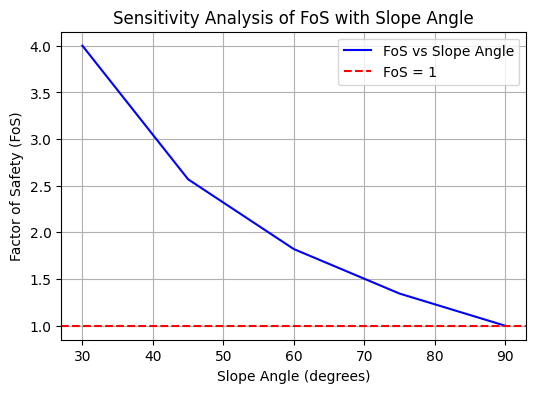

In [16]:
# Saturated slopes
import numpy as np
import matplotlib.pyplot as plt

# Define constants
cohesion = 10  # Cohesion in kPa
unit_weight = 20  # Unit weight of soil in kN/m^3
friction_angle = 30  # Friction angle in degrees
pore_pressure_ratio = 0.5  # Pore pressure ratio

# Function to calculate FoS
def calculate_fos(slope_angle):
    slope_angle_rad = np.radians(slope_angle)
    numerator = cohesion + (unit_weight * np.cos(slope_angle_rad) * np.tan(np.radians(friction_angle)))
    denominator = unit_weight * np.sin(slope_angle_rad) * (1 - pore_pressure_ratio)
    fos = numerator / denominator
    return fos

# Generate slope angles from 0 to 90 degrees
slope_angles = np.linspace(30, 90, 5)
fos_values = [calculate_fos(angle) for angle in slope_angles]

# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(slope_angles, fos_values, label='FoS vs Slope Angle', color='b')
plt.axhline(y=1, color='r', linestyle='--', label='FoS = 1')
plt.xlabel('Slope Angle (degrees)')
plt.ylabel('Factor of Safety (FoS)')
plt.title('Sensitivity Analysis of FoS with Slope Angle')
plt.legend()
plt.grid(True)
plt.show()

Dry slope FOS does not involve any pore pressure into the equation where as saturated slopes take into effect the pore pressure.